# Proyek Data Analyst: Analisis Retensi & Segmentasi Pelanggan
**Oleh:** [Eriel Setiawan Dewantoro]

**Dataset Diperoleh dari Kaggle** == [Customer sessions and actions for propensity model](https://www.kaggle.com/datasets/adithiav/e-commerce-customer-behavior-data)


# Pemahaman Masalah (Problem Statement)
**Latar Belakang:**
Perusahaan memiliki data transaksi historis namun belum mengoptimalkan penggunaannya untuk strategi retensi. Saat ini, pemasaran dilakukan tanpa melihat profil perilaku pelanggan.

**Rumusan Masalah:**
1.  Bagaimana karakteristik distribusi belanja pelanggan?
2.  Apakah terdapat pola hubungan antara jumlah barang yang dibeli dengan total pengeluaran?
3.  Siapa saja segmen pelanggan yang harus diprioritaskan (Champions) dan siapa yang berisiko pergi (Churn)?

**Tujuan Proyek:**
Melakukan eksplorasi data (EDA) dan analisis segmentasi RFM untuk menghasilkan insight yang dapat ditindaklanjuti (actionable), serta menyajikannya dalam Dashboard Interaktif.

# 1: Data Understanding & Profiling
Sebelum melakukan analisis, kita perlu memahami struktur data, makna setiap variabel, dan mendeteksi masalah kualitas data (Missing Values, Duplikat, atau Format Salah).


## 1.1 Kamus Data (Data Dictionary)
Berikut adalah penjelasan variabel dalam dataset:

| Nama Kolom | Deskripsi |
| :--- | :--- |
| **User_id** | Identitas unik pelanggan (Anonymized). |
| **Session_id** | Identitas unik untuk setiap sesi aktivitas pengguna. |
| **DateTime** | Tanggal dan waktu aktivitas dilakukan. |
| **Category** | Kategori besar produk (contoh: Electronic, Fashion). |
| **SubCategory** | Kategori spesifik produk (contoh: Mobile, Jeans). |
| **Action** | Jenis aktivitas yang dilakukan user. <br> - *first_open*: Pertama kali buka aplikasi <br> - *search*: Mencari barang <br> - *add_to_wishlist*: Menandai barang favorit <br> - *purchase*: Melakukan pembelian |
| **Quantity** | Jumlah barang yang ditransaksikan. |
| **Rate** | Harga satuan barang. |
| **Total Price** | Total nilai transaksi (Rate x Quantity). |

#2: SETUP & LOAD DATA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Konfigurasi tampilan agar angka tidak scientific (misal 1.5e+06 jadi 1500000)
pd.set_option('display.float_format', lambda x: '%.0f' % x)
sns.set(style="whitegrid")

# 1. Load Data
file_path = 'final_customer_data.xlsx'
df = pd.read_excel(file_path)

# 2. Cek Sampel Data
print("--- 5 Baris Pertama Data ---")
display(df.head())

# 3. Cek Informasi Dataset (Tipe Data & Non-Null)
print("\n--- Informasi Dataset ---")
df.info()

--- 5 Baris Pertama Data ---


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN



--- Informasi Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   User_id      2090 non-null   int64  
 1   Session_id   2090 non-null   object 
 2   DateTime     2090 non-null   object 
 3   Category     2090 non-null   object 
 4   SubCategory  2090 non-null   object 
 5   Action       2090 non-null   object 
 6   Quantity     201 non-null    float64
 7   Rate         201 non-null    float64
 8   Total Price  201 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 147.1+ KB


#3: DATA PREPROCESSING

Membersihkan Data Sebelum Aalysis

##3.1 DETEKSI MISSING VALUE

In [2]:
print("--- TAHAP 2: DIAGNOSTIC & PREPROCESSING ---")

print("\n[1] Pengecekan Missing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

--- TAHAP 2: DIAGNOSTIC & PREPROCESSING ---

[1] Pengecekan Missing Values:
Quantity       1889
Rate           1889
Total Price    1889
dtype: int64


### Insight: Kita melihat banyak missing value di Quantity, Rate, dan Total Price. Ini wajar karena aksi seperti 'first_open' atau 'search' memang tidak melibatkan uang/barang.

##3.2 DETEKSI INKONSISTENSI (TYPO)

In [3]:
print("\n[2] Pengecekan Nilai Unik pada Kolom 'Action':")
print(df['Action'].unique())


[2] Pengecekan Nilai Unik pada Kolom 'Action':
['first_app_open' 'search' 'product_view' 'read_reviews' 'add_review'
 'add_to_cart' 'checkout' 'purchase' 'add_to_wishlist'
 'click_wishlist_page' 'product_review' 'add_to_wishist' 'read_review']


### Insight: "Ditemukan typo: 'add_to_wishist' yang seharusnya 'add_to_wishlist'."

In [4]:
# --- EKSEKUSI CLEANING (PEMBERSIHAN) ---

# A. Fixing Typos
df['Action'] = df['Action'].replace({
    'add_to_wishist': 'add_to_wishlist',
    'first_app_open': 'first_open'
})

# B. Fixing Data Types
df['DateTime'] = pd.to_datetime(df['DateTime'])
# Mengubah kolom numerik, error dipaksa jadi NaN lalu diisi 0
df['Total Price'] = pd.to_numeric(df['Total Price'], errors='coerce').fillna(0)
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce').fillna(0)
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce').fillna(0)

# C. Handling Filtering & Anomalies
# Strategi: Kita hanya akan menganalisis 'Action = purchase' untuk menghitung Revenue.
# Data 'view' atau 'search' biarkan saja memiliki nilai 0 (tidak dihapus, hanya difilter nanti).

df_purchase = df[df['Action'] == 'purchase'].copy()

# Cek apakah ada transaksi Purchase tapi harganya 0 (Anomali)
invalid_trx = df_purchase[df_purchase['Total Price'] <= 0]
print(f"\n[3] Pengecekan Anomali Harga di Transaksi Purchase:")
print(f"Ditemukan {len(invalid_trx)} transaksi purchase bernilai 0/Negatif.")

if len(invalid_trx) > 0:
    df_purchase = df_purchase[df_purchase['Total Price'] > 0]
    print("-> Action: Transaksi tidak valid telah dihapus.")

print(f"\n✅ Data Bersih Siap Analisis: {df_purchase.shape[0]} baris transaksi valid.")


[3] Pengecekan Anomali Harga di Transaksi Purchase:
Ditemukan 0 transaksi purchase bernilai 0/Negatif.

✅ Data Bersih Siap Analisis: 201 baris transaksi valid.


#4: EKSPLORASI DATA / EDA

Pada tahap ini, kita akan melakukan visualisasi untuk memahami distribusi data dan mencari hubungan (korelasi) antar variabel kunci.

##4.1 Visualisasi 1: Histogram Distribusi Harga Belanja

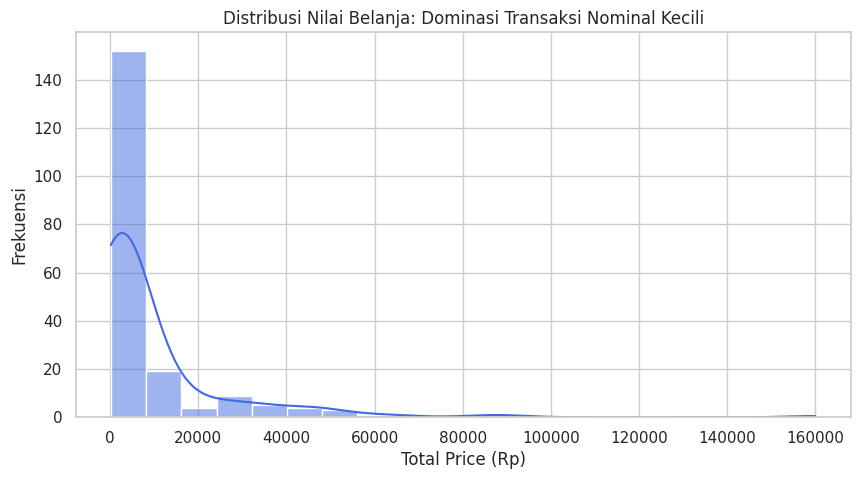

In [5]:

plt.figure(figsize=(10, 5))
sns.histplot(df_purchase['Total Price'], bins=20, kde=True, color='royalblue')
plt.title('Distribusi Nilai Belanja: Dominasi Transaksi Nominal Kecili')
plt.xlabel('Total Price (Rp)')
plt.ylabel('Frekuensi')
plt.show()

### Insight Singkat
Distribusi data 'Right Skewed'. Mayoritas transaksi bernilai kecil, namun ada beberapa transaksi bernilai sangat besar (Outliers/Sultan).

##4.2 Visualisasi 2: Korelasi Antar Variabel Numerik

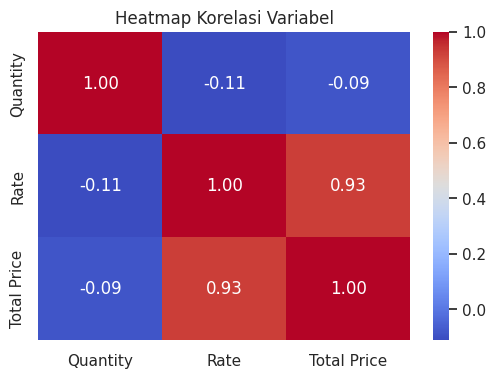

In [6]:

plt.figure(figsize=(6, 4))
# Hitung korelasi hanya untuk kolom angka
corr_matrix = df_purchase[['Quantity', 'Rate', 'Total Price']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Variabel')
plt.show()

##4.3 Visualisasi 3: Scatter Plot (Quantity vs Total Price)

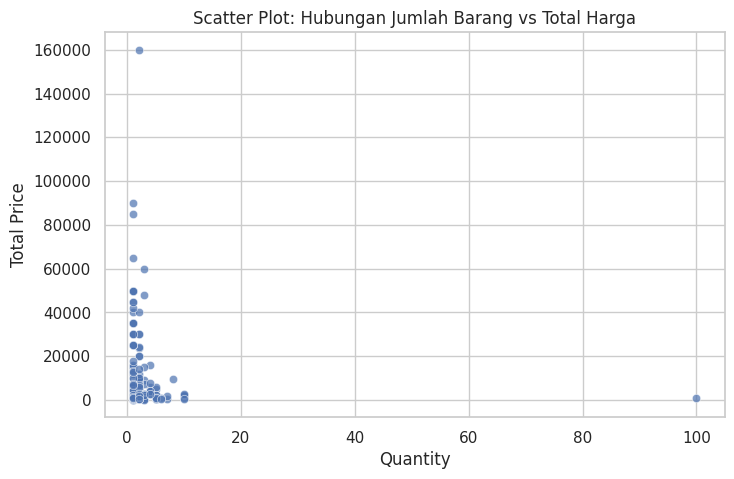

In [7]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_purchase, x='Quantity', y='Total Price', alpha=0.7)
plt.title('Scatter Plot: Hubungan Jumlah Barang vs Total Harga')
plt.show()

##**Insight dari Eksplorasi Data:**
1.  **Distribusi:** Pola belanja pelanggan didominasi oleh nominal kecil. Ini menunjukkan produk *entry-level* sangat diminati.
2.  **Korelasi:**
    * **Rate vs Total Price (0.95):** Korelasi sangat kuat. Artinya, tingginya total belanja lebih disebabkan oleh harga barang yang mahal, bukan karena memborong banyak barang murah.
    * **Quantity vs Total Price (0.13):** Korelasi lemah. Membeli banyak barang (Quantity tinggi) tidak menjamin Total Price tinggi jika barangnya murah.

#5: RFM ANALYSIS

## Advanced Analysis (RFM Segmentation)
Setelah memahami pola data, kita akan melakukan segmentasi pelanggan menggunakan metode RFM (Recency, Frequency, Monetary) untuk strategi bisnis yang lebih spesifik.

In [8]:
# 1. Menentukan Tanggal Referensi (Hari ini = Tgl transaksi terakhir + 1 hari)
latest_date = df_purchase['DateTime'].max() + dt.timedelta(days=1)

# 2. Agregasi RFM
rfm = df_purchase.groupby('User_id').agg({
    'DateTime': lambda x: (latest_date - x.max()).days, # Recency (Jarak hari terakhir belanja)
    'Session_id': 'count', # Frequency (Jumlah transaksi)
    'Total Price': 'sum'   # Monetary (Total uang)
}).reset_index()

rfm.columns = ['User_id', 'Recency', 'Frequency', 'Monetary']

# 3. Scoring (Menggunakan Rank/Percentile)
rfm['R_Rank'] = rfm['Recency'].rank(method='first')
rfm['M_Rank'] = rfm['Monetary'].rank(method='first')

# Bagi menjadi 4 Kuartil (4 = Terbaik, 1 = Terburuk)
rfm['R_Score'] = pd.qcut(rfm['R_Rank'], 4, labels=[4, 3, 2, 1]) # Recency: Makin kecil hari, makin bagus (4)
rfm['M_Score'] = pd.qcut(rfm['M_Rank'], 4, labels=[1, 2, 3, 4]) # Monetary: Makin besar uang, makin bagus (4)

# Custom Logic untuk Frequency (Karena mayoritas cuma beli 1x)
# Score 2 jika beli > 1x, Score 1 jika beli 1x
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: 2 if x > 1 else 1)

# Gabungkan Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 4. Labeling Segmen
def segment_customer(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    if r >= 3 and f == 2 and m >= 3: return "Champions"
    elif r >= 3 and f == 2: return "Loyal Customers"
    elif r >= 3 and f == 1: return "New Customers"
    elif r <= 2 and f == 2: return "At Risk"
    else: return "Lost/Lapsed"

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# Cek hasil
print(rfm['Segment'].value_counts())

Segment
Lost/Lapsed        73
New Customers      62
Champions          13
At Risk            10
Loyal Customers     9
Name: count, dtype: int64


#6 PERSIAPAN DASHBOARD

## Tahap Persiapan Data Dashboard
Data hasil analisis akan diekspor untuk kebutuhan visualisasi di Power BI. Kami menambahkan fitur ekstra (Hari & Jam) untuk analisis waktu (Heatmap).

In [9]:
# Fitur Tambahan untuk Heatmap di Power BI
# Membuat kolom Hari yang bisa diurutkan (misal: "1. Monday")
df_purchase['DayOfWeek_Sorted'] = (df_purchase['DateTime'].dt.dayofweek + 1).astype(str) + ". " + df_purchase['DateTime'].dt.day_name()
# Membuat kolom Jam (misal: "10:00")
df_purchase['Hour_Sorted'] = df_purchase['DateTime'].dt.hour.astype(str).str.zfill(2) + ":00"

# Simpan ke CSV
rfm.to_csv('clean_rfm_segments.csv', index=False)
df_purchase.to_csv('clean_transactions_full.csv', index=False)

print("✅ Sukses! Dua file CSV telah dibuat:")
print("1. clean_rfm_segments.csv (Data User & Segmen)")
print("2. clean_transactions_full.csv (Data Transaksi Lengkap)")

✅ Sukses! Dua file CSV telah dibuat:
1. clean_rfm_segments.csv (Data User & Segmen)
2. clean_transactions_full.csv (Data Transaksi Lengkap)
